## Function to calculate neural predictions for a single element

In [17]:
%pylab inline
import torch
from torch.autograd import Variable
from Chempy.parameter import ModelParameters
a = ModelParameters
a.neurons = 40 # 10 neurons
a.epochs = 1000
learning_rate = 0.01
element_index = 0

Populating the interactive namespace from numpy and matplotlib


In [70]:
def single_neural(lr,element_index,neurons=a.neurons):

    training_abundances = np.load('Neural/training_abundances.npy')
    tr_input = np.load('Neural/training_norm_grid.npy')
    tr_output = training_abundances[:,element_index]

    dim_in = tr_input.shape[1]
    dim_out = 1

    tr_input = Variable(torch.from_numpy(tr_input)).type(torch.FloatTensor)
    tr_output = Variable(torch.from_numpy(tr_output), requires_grad=False).type(torch.FloatTensor)

    model = []
    model = torch.nn.Sequential(
        torch.nn.Linear(dim_in,neurons),
        torch.nn.Tanh(),
        torch.nn.Linear(neurons,dim_out)
        )
    loss_fn = torch.nn.L1Loss(size_average=True)


    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    losslog = []
    epoch = []

    # Train neural network
    for i in range(a.epochs):
        pred_output = model(tr_input)
        loss = loss_fn(pred_output, tr_output)
        optimizer.zero_grad() # Initially zero gradient
        loss.backward() # Backpropagation
        optimizer.step() # Update via optimizer

        # Output loss
        if i % 3 ==0:
            losslog.append(loss.data[0])
            epoch.append(i)
        if i % 100==0:
            print("Training epoch %d of %d complete" %(i,a.epochs))

    # Convert weights to numpy arrays
    model_numpy = []
    for param in model.parameters():
        model_numpy.append(param.data.numpy())
        
    w_array_0=model_numpy[0]
    b_array_0=model_numpy[1]
    w_array_1=model_numpy[2]
    b_array_1=model_numpy[3]
    
    np.save('SingleElement/w0.npy',w_array_0)
    np.save('SingleElement/w1.npy',w_array_1)
    np.save('SingleElement/b0.npy',b_array_0)
    np.save('SingleElement/b1.npy',b_array_1)
    
    # Test network
    all_abun = np.load('Neural/verif_abundances.npy')
    test_abun = all_abun[:,element_index]
    test_param = np.load('Neural/verif_param_grid.npy')

    err = []
    for i,item in enumerate(test_param):
        norm_data = (item - a.p0)/np.array(a.training_widths)
        hidden1 = np.tanh(np.array(np.dot(w_array_0,norm_data)+b_array_0))
        output = np.dot(w_array_1, hidden1)+b_array_1
        err.append(np.absolute(output-test_abun[i]))
    print(np.median(err),max(err),min(err))
    return np.median(err),np.std(err),epoch,losslog

In [19]:
def neural_pred(test_param):
    """
    Predict element output from pre-trained neural network
    """
    # Load coefficients
    w_array_0 = np.load('SingleElement/w0.npy')
    w_array_1 = np.load('SingleElement/w1.npy')
    b_array_0 = np.load('SingleElement/b0.npy')
    b_array_1 = np.load('SingleElement/b1.npy')
        
    norm_data = (test_param - a.p0)/np.array(a.training_widths)
    hidden1 = np.tanh(np.array(np.dot(w_array_0,norm_data)+b_array_0))
    output = np.dot(w_array_1, hidden1)+b_array_1
    return output

In [ ]:
error = []
stderr = []
learning_rate = [0.01]
neurons = 10
for lr in learning_rate:
    print(lr)
    er,ste,epoch,losslog,w_array_0,b_array_0,w_array_1,b_array_1 = single_neural(lr,element_index,neurons)
    error.append(er)
    stderr.append(ste)
    plt.plot(epoch,losslog)

In [ ]:
plt.errorbar((learning_rate),error,yerr=stderr)


In [ ]:
# Create random parameters up to 3 sigma from mean
from Chempy.cem_function import posterior_function_returning_predictions
err = []
sigma = np.array([0.3,0.3,0.3,0.3,0.1,0.1])
Ntest = 500
param = np.zeros((Ntest,len(a.p0)))
for i in range(Ntest):
    print(i)
    param[i,:] = a.p0+3*sigma*np.random.rand(6)
    rescaled_param = (param[i,:]-a.p0)/np.array(a.training_widths)
    hidden1 = np.tanh(np.array(np.dot(w_array_0,rescaled_param)+b_array_0))
    neural_output = np.dot(w_array_1, hidden1)+b_array_1
    abun,_= posterior_function_returning_predictions((param[i,:],a))
    chem_output = abun[element_index]
    err.append(np.absolute(chem_output-neural_output))


In [ ]:
plt.scatter(param[:,0],param[:,1],c=err)
plt.colorbar()

## New testing of dataset

[0.016025219887305341, 0.016960882934654305, 0.047589471591412802, 0.099110594333807062, 0.10847095278927554] [0.0018837098826944808, 0.0021493873680176589, 0.0064055507339572312, 0.0095992383489005798, 0.011362435639802642]


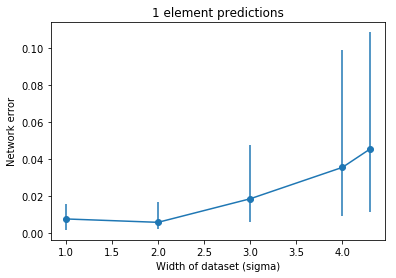

In [22]:
widths = [1,2,3,4,4.3]
err_median = []
err_up = []
err_low = []
for width in widths:
    tr_abun = np.load('SingleElement/'+str(width)+'_sigma_abundances.npy')[:,element_index]
    tr_param = np.load('SingleElement/'+str(width)+'_sigma_param_grid.npy')
    
    err = []
    for i,param in enumerate(tr_param):
        neural_abun = neural_pred(param)
        err.append(np.absolute(neural_abun-tr_abun[i]))
    err_median.append(np.percentile(err,50))
    err_up.append(np.percentile(err,100-15.865))
    err_low.append(np.percentile(err,15.865))
                   
errorbar_widths = [np.array(err_median)-np.array(err_low),np.array(err_up)-np.array(err_median)]
plt.errorbar(widths,err_median,yerr = errorbar_widths,fmt='-o')
plt.ylabel('Network error')
plt.xlabel('Width of dataset (sigma)')
plt.title('1 element predictions')
print(err_up,err_low)

In [ ]:
# For all elements
from Chempy.neural import neural_output
widths = [1,2,3,4,4.3]
err_median = []
err_up = []
err_low = []
for width in widths:
    tr_abun = np.load('SingleElement/'+str(width)+'_sigma_abundances.npy')[:]
    tr_param = np.load('SingleElement/'+str(width)+'_sigma_param_grid.npy')
    
    err = []
    for i,param in enumerate(tr_param):
        neural_abun = neural_output(param)
        temp_err = (np.absolute(neural_abun-tr_abun[i]))
        err.append(mean(temp_err))
    err_median.append(np.percentile(err,50))
    err_up.append(np.percentile(err,100-15.865))
    err_low.append(np.percentile(err,15.865))
                   
errorbar_widths = [np.array(err_median)-np.array(err_low),np.array(err_up)-np.array(err_median)]
plt.errorbar(widths,err_median,yerr = errorbar_widths,fmt='-o')
plt.ylabel('Mean network error across all elements')
plt.xlabel('Width of dataset (sigma)')
plt.title('Network for all 28 elements')

## Optimizing network with 3 sigma ranges

In [20]:
def single_3sigma(lr,element_index,neurons=a.neurons):

    training_abundances = np.load('Neural/training_abundances.npy')
    tr_input = np.load('Neural/training_norm_grid.npy')
    tr_output = training_abundances[:,element_index]

    dim_in = tr_input.shape[1]
    dim_out = 1

    tr_input = Variable(torch.from_numpy(tr_input)).type(torch.FloatTensor)
    tr_output = Variable(torch.from_numpy(tr_output), requires_grad=False).type(torch.FloatTensor)

    model = []
    model = torch.nn.Sequential(
        torch.nn.Linear(dim_in,neurons),
        torch.nn.Tanh(),
        torch.nn.Linear(neurons,dim_out)
        )
    loss_fn = torch.nn.L1Loss(size_average=True)


    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    losslog = []
    epoch = []

    # Train neural network
    for i in range(a.epochs):
        pred_output = model(tr_input)
        loss = loss_fn(pred_output, tr_output)
        optimizer.zero_grad() # Initially zero gradient
        loss.backward() # Backpropagation
        optimizer.step() # Update via optimizer

        # Output loss
        if i % 3 ==0:
            losslog.append(loss.data[0])
            epoch.append(i)
        if i % 500==0:
            print("Training epoch %d of %d complete" %(i,a.epochs))

    # Convert weights to numpy arrays
    model_numpy = []
    for param in model.parameters():
        model_numpy.append(param.data.numpy())
        
    w_array_0=model_numpy[0]
    b_array_0=model_numpy[1]
    w_array_1=model_numpy[2]
    b_array_1=model_numpy[3]
    
    np.save('SingleElement/w0.npy',w_array_0)
    np.save('SingleElement/w1.npy',w_array_1)
    np.save('SingleElement/b0.npy',b_array_0)
    np.save('SingleElement/b1.npy',b_array_1)
    
    # Test network
    all_abun = np.load('SingleElement/3_sigma_abundances.npy')
    test_abun = all_abun[:,element_index]
    test_param = np.load('SingleElement/3_sigma_param_grid.npy')

    err = []
    for i,item in enumerate(test_param):
        norm_data = (item - a.p0)/np.array(a.training_widths)
        hidden1 = np.tanh(np.array(np.dot(w_array_0,norm_data)+b_array_0))
        output = np.dot(w_array_1, hidden1)+b_array_1
        err.append(abs(output-test_abun[i]))
    
    err_median =(np.percentile(err,50))
    err_up =(np.percentile(err,100-15.865))
    err_low =(np.percentile(err,15.865))
    return err_median,err_up,err_low

In [21]:
learning_rate = [0.007] # This seems to be best number
neurons = [30]
err_med = []
err_low = []
err_up=[]
for n in neurons:
    print("%d neurons testing" %(n))
    med,low,up = single_3sigma(learning_rate[-1],element_index,n)
    err_med.append(med)
    err_low.append(low)
    err_up.append(up)
print(err_med)

30 neurons testing
Training epoch 0 of 1000 complete
Training epoch 500 of 1000 complete
[0.018683320645638879]


In [ ]:
errorbar_widths = [np.array(err_med)-np.array(err_low),np.array(err_up)-np.array(err_med)]
plt.errorbar(neurons,err_med,yerr = errorbar_widths,fmt='o')
plt.ylabel('3 sigma network error across all elements')
plt.xlabel('No. neurons')
plt.title('Error plot for optimization using 3 sigma test set')

In [ ]:
errorbar_widths = [np.array(err_med)-np.array(err_low),np.array(err_up)-np.array(err_med)]
plt.errorbar(learning_rate,err_med,yerr = errorbar_widths,fmt='o')
plt.ylabel('3 sigma network error across all elements')
plt.xlabel('Learning rate')
plt.title('Error plot for optimization using 3 sigma test set')

##### This gives best output for 30 neurons at learning_rate = 0.007. Best output is err = 0.0058+0.0092-0.0047 for the 3sigma test set

## Compute best errors from all 28 elements at once

Populating the interactive namespace from numpy and matplotlib
[ 0.00414226  0.00686105  0.00987227  0.02347043  0.03776999]


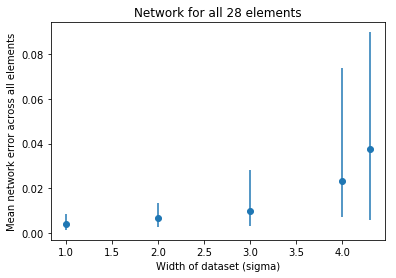

In [16]:
%pylab inline
from Chempy.neural import create_network
from Chempy.neural import neural_output

# Create neural network

#create_network(learning_rate=0.007,Plot=False)

widths = [1,2,3,4,4.3]
err_median = []
err_up = []
err_low = []
for width in widths:
    # Use training data of restricted sigma ranges
    tr_abun = np.load('SingleElement/'+str(width)+'_sigma_abundances.npy')[:]
    tr_param = np.load('SingleElement/'+str(width)+'_sigma_param_grid.npy')
    
    err = []
    for i,param in enumerate(tr_param):
        neural_abun = neural_output(param)
        temp_err = (np.absolute(neural_abun-tr_abun[i]))
        err.append(temp_err)
    err_median.append(np.percentile(err,50,axis=0))
    err_up.append(np.percentile(err,100-15.865,axis=0))
    err_low.append(np.percentile(err,15.865,axis=0))

j=0 # Element index                

errorbar_widths = [np.array(err_median)[:,j]-np.array(err_low)[:,j],np.array(err_up)[:,j]-np.array(err_median)[:,j]]
plt.errorbar(widths,np.array(err_median)[:,j],yerr = errorbar_widths,fmt='o')
plt.ylabel('Mean network error across all elements')
plt.xlabel('Width of dataset (sigma)')
plt.title('Network for all 28 elements')
print(np.array(err_median)[:,j])

## Compare all elements vs each in turn

In [71]:
# For each element in turn
err_med = []
up_bar = []
low_bar = []
a.epochs=500
from Chempy.score_function import preload_params_mcmc
preload = preload_params_mcmc()
elements = []
for item in a.elements_to_trace:
    if item in preload.wildcard.dtype.names:
        elements.append(item)

for i in range(len(elements)):
    element_index = i
    print('Using element %d of %d only' %(element_index,len(elements)))
    med,low,up = single_3sigma(0.007,element_index,30)
    err_med.append(med)
    up_bar.append(up-med) # For error bars
    low_bar.append(med-low)
    
# For all elements at once
from Chempy.neural import create_network
from Chempy.neural import neural_output
create_network(learning_rate=0.007,Plot=False)

width = 3

print('Using all elements simulatenously')
# Use training data of restricted sigma ranges
tr_abun = np.load('SingleElement/'+str(width)+'_sigma_abundances.npy')[:]
tr_param = np.load('SingleElement/'+str(width)+'_sigma_param_grid.npy')
  
err = []
for j,param in enumerate(tr_param):
    neural_abun = neural_output(param)
    temp_err = (np.absolute(neural_abun-tr_abun[j]))
    err.append(temp_err)
err_med2=(np.percentile(err,50,axis=0))
up_bar2=(np.percentile(err,100-15.865,axis=0)-np.percentile(err,50,axis=0))
low_bar2=(np.percentile(err,50,axis=0)-np.percentile(err,15.865,axis=0))


Using element 0 of 28 only
Training epoch 0 of 500 complete
Using element 1 of 28 only
Training epoch 0 of 500 complete
Using element 2 of 28 only
Training epoch 0 of 500 complete
Using element 3 of 28 only
Training epoch 0 of 500 complete
Using element 4 of 28 only
Training epoch 0 of 500 complete
Using element 5 of 28 only
Training epoch 0 of 500 complete
Using element 6 of 28 only
Training epoch 0 of 500 complete
Using element 7 of 28 only
Training epoch 0 of 500 complete
Using element 8 of 28 only
Training epoch 0 of 500 complete
Using element 9 of 28 only
Training epoch 0 of 500 complete
Using element 10 of 28 only
Training epoch 0 of 500 complete
Using element 11 of 28 only
Training epoch 0 of 500 complete
Using element 12 of 28 only
Training epoch 0 of 500 complete
Using element 13 of 28 only
Training epoch 0 of 500 complete
Using element 14 of 28 only
Training epoch 0 of 500 complete
Using element 15 of 28 only
Training epoch 0 of 500 complete
Using element 16 of 28 only
Traini

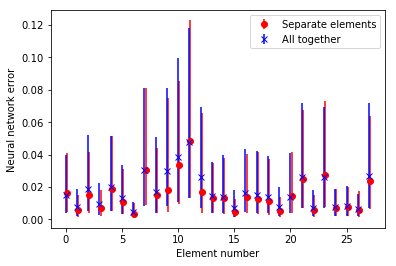

In [75]:
# Plot for each element
x = range(len(elements))
plt.clf()
errorbars1 = [low_bar,up_bar]
errorbars2 = [low_bar2,up_bar2]
plt.errorbar(x+0.1*np.ones(len(x)),err_med,yerr=errorbars1,c='r',fmt='o',label='Separate elements')
plt.errorbar(x,err_med2,yerr=errorbars2,c='b',fmt='x',label='All together')
plt.xlabel('Element number')
plt.ylabel('Neural network error')
plt.legend()

In [78]:
elements[11]

'Ge'

In [81]:
preload.wildcard.dtype.names[7]

'Mg'

In [82]:
init_param

NameError: name 'init_param' is not defined